##### Imports

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sea
from tqdm.notebook import tqdm
import cv2

plt.style.use('seaborn')

np.__version__


/tmp/ipykernel_17942/1268372010.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


'1.24.4'

## Q1: Own Calibration

#### Loading the image

Resized the image to (1080, 720) because it was too large and working with it consumed a lot of memory

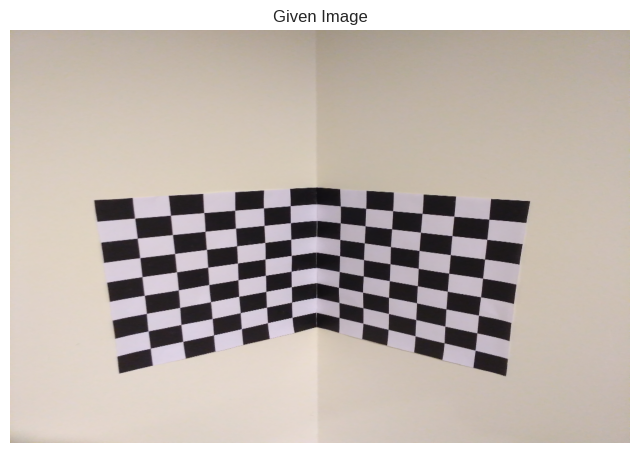

In [160]:
img = cv2.imread('./Data/calib-object.jpg')
img = cv2.resize(img, (1080, 720))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img)
plt.title('Given Image')
plt.axis('off')
plt.show()


#### 1. Detecting Corners

Used ```cv2.goodFeaturesToTrack()``` function to find corners with parameters: ```maxCorners=200, qualityLevel=0.15,  minDistance=10```

Total corners found: 146


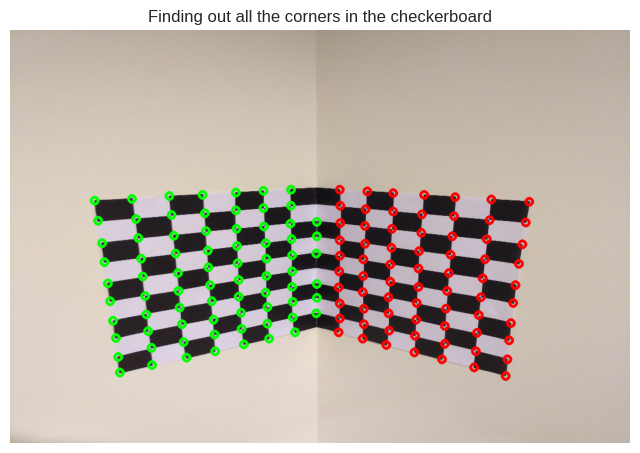

In [161]:
corners = cv2.goodFeaturesToTrack(img_gray, maxCorners=200, qualityLevel=0.15,  minDistance=10)
corners = np.intp(corners).reshape(-1, 2)
img_corners = img.copy()
points_3d = []

for corner in corners:
    points_3d.append([corner[0], corner[1], 0] if corner[0] <= 540 else
                     [540, corner[1], -corner[0] + 540])
    color = (255, 0, 0) if corner[0] >= 540 else (0, 255, 0)
    img_corners = cv2.circle(img_corners, (int(corner[0]), int(corner[1])), 6, color, 4)
    
    
plt.imshow(img_corners)
plt.title("Finding out all the corners in the checkerboard")
plt.axis('off')

print(f"Total corners found: {len(corners)}")

In [150]:

# 299, 513 -> 4, 16, 0
# 351, 473 -> 6, 14, 0
# 489, 307 -> 12, 2, 0
# 659, 466 -> 14, 14, 6
# 618, 373 -> 14, 6, 4
# 773, 325 -> 14, 2, 10
# 575, 337 -> 14, 4, 2
# 398, 465 -> 8, 12, 0
# 407, 548 -> 10, 18, 0
# 356, 531 -> 8, 16, 0
# 712, 386 -> 14, 6, 8


# points_3d = np.array([
#     [4, 14, 0], 
#     [6, 12, 0], 
#     [12, 2, 0], 
#     [14, 14, -6], 
#     [14, 6, -4],
#     [14, 2, -10],
#     [14, 4, -2],
#     [8, 12, 0], 
#     [10, 18, 0], 
#     [8, 16, 0],
#     [14, 6, -8],
#     [14, 8, -2], 
#     [6, 4, 0],
#     [2, 4, 0],
#     [14, 8, -6],
#     [14, 16, -2], 
#     [4, 10, 0], 
#     [14, 0, -4],
#     [4, 6, 0],
#     [14, 16, -8],
#     [14, 0, -12]
    
    
# ])
# points_2d = np.array([
#     [299, 513], 
#     [351, 473],
#     [489, 307],
#     [659, 466],
#     [618, 373],
#     [773, 325],
#     [575, 337], 
#     [398, 465], 
#     [407, 548], 
#     [356, 531], 
#     [712, 386],
#     [574, 394], 
#     [341, 351],
#     [223, 363], 
#     [662, 409], 
#     [574, 503], 
#     [293, 455], 
#     [622, 282], 
#     [288, 390], 
#     [705, 533],
#     [838, 296]
# ])



# points_2d = np.hstack((points_2d, np.ones((len(points_2d), 1)))) @ T_2d.T
# points_3d = np.hstack((points_3d, np.ones((len(points_3d), 1)))) @ T_3d.T

# points_2d, points_3d = points_2d[:, :-1], points_3d[:, :-1]


#### 2. Implementing Camera Calibration
Used the Direct Linear Transform method for finding the Projection Matrix (P) of the camera.

##### 2.1 Finding 3D-2D point correspondences

In [163]:

def get_correspondences(img, first_half=True):
    if first_half:
        img[:, 540:] = np.zeros_like(img[:, 540:])
    else:
        img[:, :540] = np.zeros_like(img[:, :540])
    
    ret, corners = cv2.findChessboardCorners(img, (8, 5))
    corners = corners.reshape(-1, 2)
    points_2d = corners[np.argsort(corners[:, 0])]
    points_3d = []
    
    for i in range(5):
        for j in range(8):
            if first_half:
                points_3d.append([2 + 2*i, 2 + 2*j, 0])
            else:
                points_3d.append([14, 16 - 2*j, -2*i - 4])
    
    return np.array(points_2d), np.array(points_3d)


T_2d = np.array([
    [2/1080, 0,     -1],
    [0,      2/720, -1],
    [0,      0,      1]
])

T_3d = np.array([
    [1/20, 0,    0,    0],
    [0,    1/20, 0,    0],
    [0,    0,    1/20, 0],
    [0,    0,    0,    1]
])

points_2d_left, points_3d_left = get_correspondences(img_gray.copy(), first_half=True)
points_2d_right, points_3d_right = get_correspondences(img_gray.copy(), first_half=False)

points_2d = np.concatenate([points_2d_left, points_2d_right], axis=0)
points_3d = np.concatenate([points_3d_left, points_3d_right], axis=0)

points_2d.shape, points_3d.shape

((80, 2), (80, 3))

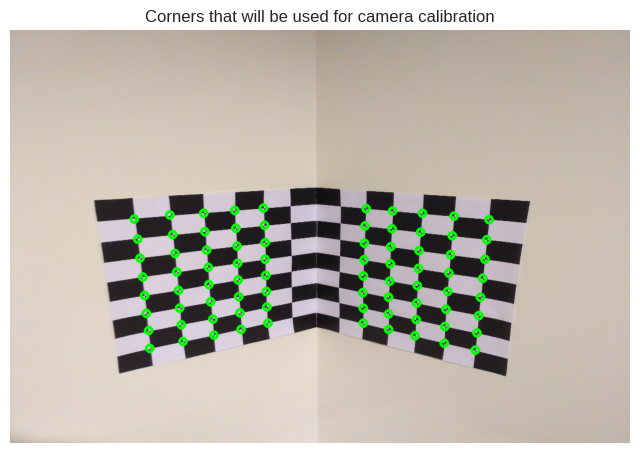

In [165]:
img_corners = img.copy()

for corner in points_2d:
    img_corners = cv2.circle(img_corners, (int(corner[0]), int(corner[1])), 6, (0, 255, 0), 3)
    
plt.imshow(img_corners)
plt.title('Corners that will be used for camera calibration')
plt.axis('off')
plt.show()


##### 2.2 Normalizing the 2D and 3D points for numerical stability while computing the SVD.

In [153]:

points_2d = np.hstack((points_2d, np.ones((len(points_2d), 1)))) @ T_2d.T
points_3d = np.hstack((points_3d, np.ones((len(points_3d), 1)))) @ T_3d.T

points_2d, points_3d = points_2d[:, :-1], points_3d[:, :-1]

points_2d.shape, points_3d.shape

((80, 2), (80, 3))

##### 2.3 Finding P and decomposing P into K, R, t

In [154]:
def find_PKRt(points_2d, points_3d):
    A = []

    for p3d, p2d in zip(points_3d, points_2d):
        X, Y, Z = p3d
        x, y = p2d
        axi = [-X, -Y, -Z, -1,  0,  0,  0,  0, x*X, x*Y, x*Z, x]
        ayi = [0,   0,  0,  0, -X, -Y, -Z, -1, y*X, y*Y, y*Z, y]
        A.append(axi)
        A.append(ayi)
    
    A = np.array(A)
    U, S, Vt = np.linalg.svd(A)
    P = Vt[-1].reshape(3, 4)
    H, h = P[:3, :3], P[:, -1]
    Xo = -np.linalg.inv(H) @ h
    
    q, r = np.linalg.qr(np.linalg.inv(H))
    R = q.T
    K = np.linalg.inv(r)
    K = K/K[-1, -1]

    invert = np.array([
        [-1, 0, 0],
        [0, -1, 0],
        [0, 0, 1]
    ])

    R = invert @ R
    K = K @ invert
        
    return P, K, R, Xo


P, K, R, Xo = find_PKRt(points_2d, points_3d)

In [155]:
print(f"P: \n{P}\n")
print(f"K: \n{K}\n")
print(f"R: \n{R}\n")
print(f"Xo: \n{Xo}\n")


P: 
[[ 0.46236394  0.00187216 -0.42458863 -0.33032278]
 [-0.08720996  0.44941478 -0.08632196 -0.07315182]
 [ 0.162621    0.056493    0.19483134  0.45480682]]

K: 
[[ 2.41178688 -0.02848651 -0.10987764]
 [ 0.          1.78991545 -0.08301643]
 [ 0.          0.          1.        ]]

R: 
[[ 0.76399207  0.02441052 -0.64476371]
 [-0.15839115  0.97580254 -0.15073698]
 [ 0.6254825   0.21728672  0.74937182]]

Xo: 
[-0.76394344 -0.29494608 -1.6111945 ]



#### 3. Drawing the Wireframe of the Checkerboard

In [156]:
outer_corners = np.array([
    [0, 0, 0, 1],
    [14, 0, 0, 1],
    [14, 0, -14, 1],
    [14, 18, -14, 1],
    [14, 18, 0, 1],
    [0, 18, 0, 1]
])

coords = (outer_corners @ T_3d.T) @ P.T
coords = coords/coords[:, -1].reshape(6, 1)

coords = coords @ np.linalg.inv(T_2d).T
coords

array([[147.80205389, 302.09705496,   1.        ],
       [533.66783771, 275.04038693,   1.        ],
       [902.96193011, 298.55907291,   1.        ],
       [866.64576495, 606.43169042,   1.        ],
       [535.65629523, 517.06399649,   1.        ],
       [189.03738134, 595.88571277,   1.        ]])

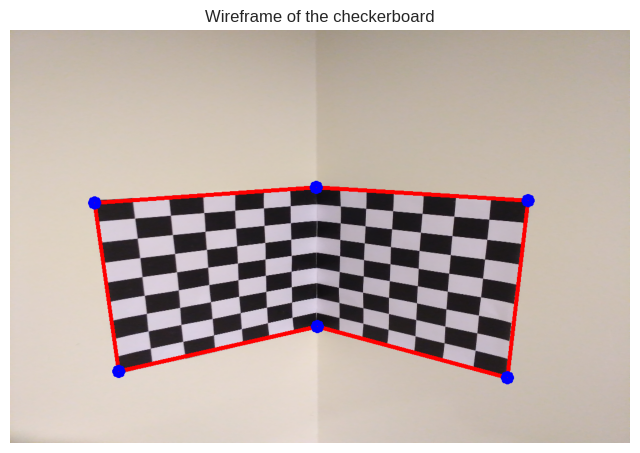

In [157]:
img_final = img.copy()

for i in range(len(coords)):
    img_final = cv2.line(img_final, 
                         (int(coords[i][0]), int(coords[i][1])), 
                         (int(coords[(i+1) % len(coords)][0]), int(coords[(i+1) % len(coords)][1])), 
                         (255, 0, 0), 5)

for corner in coords:
    img_final = cv2.circle(img_final, (int(corner[0]), int(corner[1])), 6, (0, 0, 255), 10)
    

plt.imshow(img_final)
plt.axis('off')
plt.title('Wireframe of the checkerboard')
plt.show()